In [2]:
import numpy as np 
import tensorflow as tf 
from utilities import * 
from models import HMCModel, HMC_LSTM, CoherentLSTM
import matplotlib.pyplot as plt 
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
N = 200
data1 = generate_rectangular_data(3, 4, 2, 3, size=N)
data2 = generate_rectangular_data(6, 8, 4, 5, size=N)
data = np.concatenate([data1, data2])
y1 = np.array([0.0]*N + [1.0]*N)
y2 = np.array([1.0]*N + [0.0]*N)
y3 = np.ones([N*2,1])
y = np.concatenate([y1[:,np.newaxis], y2[:,np.newaxis], y3], axis=1)
structure = np.array([[0,0,1],[0,0,1],[0,0,0]])

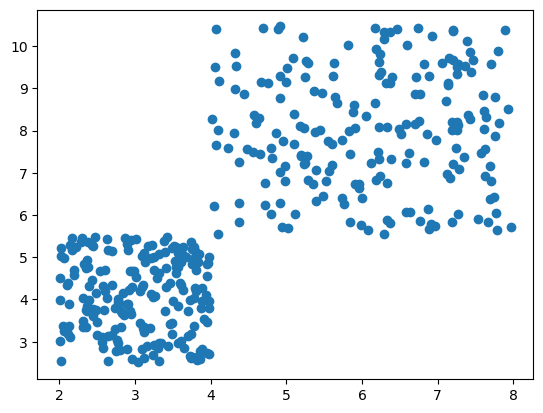

In [3]:
plt.scatter(data[:,0], data[:,1])

In [4]:
y

array([[0., 1., 1.],
       [0., 1., 1.],
       [0., 1., 1.],
       ...,
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.]])

In [4]:
idx = np.random.permutation(N*2)
train_num = int(2 * N * 6 / 10)
valid_num = int(2 * N * 2 / 10)
test_num = N * 2 - train_num - valid_num

train_idx = idx[:train_num]
valid_idx = idx[train_num:(train_num + valid_num)]
test_idx = idx[(train_num + valid_num):]

x_train, x_valid, x_test = data[train_idx], data[valid_idx], data[test_idx]
y_train, y_valid, y_test = y[train_idx], y[valid_idx], y[test_idx]

y_train = tf.convert_to_tensor(y_train, tf.float32)
y_valid = tf.convert_to_tensor(y_valid, tf.float32)
y_test = tf.convert_to_tensor(y_test, tf.float32)

In [7]:
learning_rate = 1e-2
batch_size = 64
epochs = 400

model1 = HMCModel(
    structure=structure, 
    num_classes=3, 
    hid_dim_list=[10]
)
def get_train_step_fn(model, optimizer, loss_fn):
    def train_step_fn(x, y, validation_data=None):
        with tf.GradientTape() as tape:
            logits = model(x)
            logits = model.postprocess(logits)
            loss = loss_fn(y, logits)
            
            if validation_data is not None:
                valid_x = validation_data[0]
                valid_y = validation_data[1]
                valid_logits = model(valid_x)
                valid_logits = model.postprocess(valid_logits)
                valid_loss = loss_fn(valid_y, valid_logits)
            
            variables = model.trainable_variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))
        return loss, valid_loss 
    return train_step_fn

loss_fn = get_loss_fn_sigmoid()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_fn = get_train_step_fn(model1, optimizer, loss_fn)

train_data = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).shuffle(buffer_size = N*2).batch(batch_size=batch_size)

for epoch in range(epochs):
    for x_train_batch, y_train_batch in train_data:
        loss, valid_loss = train_step_fn(
            x_train_batch, 
            y_train_batch, 
            (x_valid, y_valid)
        )
    if (epoch + 1) % (epochs // 10) == 0:
        print("epoch {}/{}, loss {}, valid loss {}".format(epoch+1, epochs, loss, valid_loss))

epoch 40/400, loss 0.04920255020260811, valid loss 0.0640503540635109
epoch 80/400, loss 0.02104119025170803, valid loss 0.022414764389395714
epoch 120/400, loss 0.003913987893611193, valid loss 0.013545406982302666
epoch 160/400, loss 0.009876844473183155, valid loss 0.009319854900240898
epoch 200/400, loss 0.0293697789311409, valid loss 0.007843296974897385
epoch 240/400, loss 0.002949920017272234, valid loss 0.005686706863343716
epoch 280/400, loss 0.0018408064497634768, valid loss 0.004593815188854933
epoch 320/400, loss 0.006582463160157204, valid loss 0.0043045636266469955
epoch 360/400, loss 0.0037247815635055304, valid loss 0.005300254561007023
epoch 400/400, loss 0.0033364465925842524, valid loss 0.0029365113005042076


In [8]:
def model1_score(model, x, y):
    logits = model(x)
    logits = model.postprocess(logits)
    prob = model.get_prob(logits)
    score = get_score(y, prob)
    return score 
train_score = model1_score(model1, x_train, y_train)
valid_score = model1_score(model1, x_valid, y_valid)
test_score = model1_score(model1, x_test, y_test)
print("AU(PRC) \n train: {}, validation {}, test {}".format(train_score, valid_score, test_score))

AU(PRC) 
 train: 0.9999956687332769, validation 1.0, test 1.0


In [10]:
learning_rate = 1e-2
batch_size = 64
epochs = 400

model1 = HMCModel(
    structure=structure, 
    num_classes=3, 
    hid_dim_list=[10]
)

def get_train_step_fn(model, optimizer, loss_fn):
    def train_step_fn(x, y, validation_data=None):
        with tf.GradientTape() as tape:
            logits = model(x)
            # logits = model.postprocess(logits)
            loss = loss_fn(y, logits)
            
            if validation_data is not None:
                valid_x = validation_data[0]
                valid_y = validation_data[1]
                valid_logits = model(valid_x)
                # valid_logits = model.postprocess(valid_logits)
                valid_loss = loss_fn(valid_y, valid_logits)
            
            variables = model.trainable_variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))
        return loss, valid_loss 
    return train_step_fn

loss_fn = get_loss_fn_coherent(structure)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_fn = get_train_step_fn(model1, optimizer, loss_fn)

train_data = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).shuffle(buffer_size = N*2).batch(batch_size=batch_size)

for epoch in range(epochs):
    for x_train_batch, y_train_batch in train_data:
        loss, valid_loss = train_step_fn(
            x_train_batch, 
            y_train_batch, 
            (x_valid, y_valid)
        )
    if (epoch + 1) % (epochs // 10) == 0:
        print("epoch {}/{}, loss {}, valid loss {}".format(epoch+1, epochs, loss, valid_loss))

epoch 40/400, loss 0.14706352353096008, valid loss 0.1471557468175888
epoch 80/400, loss 0.04578208178281784, valid loss 0.03704055771231651
epoch 120/400, loss 0.04312014579772949, valid loss 0.019574137404561043
epoch 160/400, loss 0.016133494675159454, valid loss 0.012711349874734879
epoch 200/400, loss 0.021526826545596123, valid loss 0.009731660597026348
epoch 240/400, loss 0.005915037356317043, valid loss 0.007408252451568842
epoch 280/400, loss 0.007150785997509956, valid loss 0.00611251313239336
epoch 320/400, loss 0.006983852945268154, valid loss 0.005020032171159983
epoch 360/400, loss 0.003636275650933385, valid loss 0.004293769598007202
epoch 400/400, loss 0.0032261989545077085, valid loss 0.003668472170829773


In [11]:
train_score = model1_score(model1, x_train, y_train)
valid_score = model1_score(model1, x_valid, y_valid)
test_score = model1_score(model1, x_test, y_test)
print("AU(PRC) \n train: {}, validation {}, test {}".format(train_score, valid_score, test_score))

AU(PRC) 
 train: 0.9999956776742227, validation 1.0, test 1.0


In [9]:
learning_rate = 1e-2
batch_size = 64
epochs = 400

model2 = HMC_LSTM(10, 0.5, [2,1], 2)
loss_fn = get_loss_fn_lstm(structure, 0.5, 0.5)

def get_train_step_fn(model, optimizer, loss_fn):
    def train_step_fn(x, y, validation_data=None):
        with tf.GradientTape() as tape:
            logits = model(x)
            # logits = model.postprocess(logits)
            loss = loss_fn(y, logits)
            
            if validation_data is not None:
                valid_x = validation_data[0]
                valid_y = validation_data[1]
                valid_logits = model(valid_x)
                # valid_logits = model.postprocess(valid_logits)
                valid_loss = loss_fn(valid_y, valid_logits)
            
            variables = model.trainable_variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))
        return loss, valid_loss 
    return train_step_fn

train_data = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).shuffle(buffer_size = N*2).batch(batch_size=batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_fn = get_train_step_fn(model2, optimizer, loss_fn)

for epoch in range(epochs):
    for x_train_batch, y_train_batch in train_data:
        loss, valid_loss = train_step_fn(
            x_train_batch, 
            y_train_batch, 
            (x_valid, y_valid)
        )
    if (epoch + 1) % (epochs // 10) == 0:
        print("epoch {}/{}, loss {}, valid loss {}".format(epoch+1, epochs, loss, valid_loss))

epoch 40/400, loss 0.08931010961532593, valid loss 0.08924386650323868
epoch 80/400, loss 0.014485571533441544, valid loss 0.019895924255251884
epoch 120/400, loss 0.01422206312417984, valid loss 0.009365466423332691
epoch 160/400, loss 0.008684062398970127, valid loss 0.006098650861531496
epoch 200/400, loss 0.007219887804239988, valid loss 0.00410758052021265
epoch 240/400, loss 0.0013172222534194589, valid loss 0.003328165039420128
epoch 280/400, loss 0.002453434746712446, valid loss 0.0021092011593282223
epoch 320/400, loss 0.0004178952076472342, valid loss 0.0016479757614433765
epoch 360/400, loss 0.002277718624100089, valid loss 0.0012425476452335715
epoch 400/400, loss 0.000918191100936383, valid loss 0.0010386189678683877


In [11]:
def model2_score(model, x, y):
    local_logits, global_logits = model(x)
    total_prob, _, _ = model.get_prob(local_logits, global_logits)
    score = get_score(y, total_prob)
    return score 

train_score = model2_score(model2, x_train, y_train)
valid_score = model2_score(model2, x_valid, y_valid)
test_score = model2_score(model2, x_test, y_test)
print("AU(PRC) \n train: {}, validation {}, test {}".format(train_score, valid_score, test_score))

AU(PRC) 
 train: 1.0, validation 1.0, test 0.9999805900459151


In [5]:
model3 = CoherentLSTM(10, 0.5, [2,1], 2, structure)
learning_rate = 1e-2
batch_size = 64
epochs = 400
loss_fn = get_loss_fn_coherent(structure)

def get_train_step_fn(model, optimizer, loss_fn):
    def train_step_fn(x, y, validation_data=None):
        with tf.GradientTape() as tape:
            local_logits, global_logits = model(x)
            local_loss = loss_fn(y, local_logits)
            global_loss = loss_fn(y, global_logits)
            loss = local_loss + global_loss
            
            if validation_data is not None:
                valid_x = validation_data[0]
                valid_y = validation_data[1]
                valid_local_logits, valid_global_logits = model(valid_x)
                # valid_logits = model.postprocess(valid_logits)
                valid_local_loss = loss_fn(valid_y, valid_local_logits)
                valid_global_loss = loss_fn(valid_y, valid_global_logits)
                valid_loss = valid_local_loss + valid_global_loss
            
            variables = model.trainable_variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))
        return loss, valid_loss 
    return train_step_fn

train_data = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).shuffle(buffer_size = N*2).batch(batch_size=batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_fn = get_train_step_fn(model3, optimizer, loss_fn)

for epoch in range(epochs):
    for x_train_batch, y_train_batch in train_data:
        loss, valid_loss = train_step_fn(
            x_train_batch, 
            y_train_batch, 
            (x_valid, y_valid)
        )
    if (epoch + 1) % (epochs // 10) == 0:
        print("epoch {}/{}, loss {}, valid loss {}".format(epoch+1, epochs, loss, valid_loss))


epoch 40/400, loss 0.10555948317050934, valid loss 0.09270669519901276
epoch 80/400, loss 0.027682965621352196, valid loss 0.03858707472681999
epoch 120/400, loss 0.02104182541370392, valid loss 0.031355783343315125
epoch 160/400, loss 0.009129895828664303, valid loss 0.02483813837170601
epoch 200/400, loss 0.01017936784774065, valid loss 0.014551355503499508
epoch 240/400, loss 0.004500504117459059, valid loss 0.014556234702467918
epoch 280/400, loss 0.008480665273964405, valid loss 0.01620882749557495
epoch 320/400, loss 0.005109779536724091, valid loss 0.014361580833792686
epoch 360/400, loss 0.002741436939686537, valid loss 0.009279401041567326
epoch 400/400, loss 0.0026109041646122932, valid loss 0.012662230059504509


In [6]:
def model3_score(model, x, y):
    local_logits, global_logits = model(x)
    total_prob, _, _ = model.get_prob(local_logits, global_logits)
    score = get_score(y, total_prob)
    return score 

train_score = model3_score(model3, x_train, y_train)
valid_score = model3_score(model3, x_valid, y_valid)
test_score = model3_score(model3, x_test, y_test)
print("AU(PRC) \n train: {}, validation {}, test {}".format(train_score, valid_score, test_score))

AU(PRC) 
 train: 0.9991783150288569, validation 0.9992624245213797, test 0.9984472095966339
